In [1]:
#Installing necessary modules

!pip install --upgrade pip
!pip install wordcloud
!pip install mlxtend 

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)
    100% |████████████████████████████████| 368kB 16.0MB/s 
    100% |████████████████████████████████| 1.3MB 16.4MB/s 


In [0]:
#Impporting necessary modules

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections    # The Counter() method of collections is used to do a frequency counts of a feature
import seaborn as sns
import string
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer              # Used for Lemmatizing the words
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')
import scipy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix

#1) Reading Data

In [0]:
#--------------------Reading Data from Google Drive------------------------

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file #Training Variants
downloaded = drive.CreateFile({'id':'1EwsmgZ4XleliXRfBp0ugobsDe_bzbDeZ'}) # replace the id with id of file you want to access
downloaded.GetContentFile('training_variants')  

downloaded1 = drive.CreateFile({'id':'1YPuZ4uXL0avzyzqb9eGvY9wTpOet5pfr'}) # replace the id with id of file you want to access     #Training Text
downloaded1.GetContentFile('training_text')

downloaded2 = drive.CreateFile({'id':'1HbfK82k27JPVDdWrU9k6oOaL1kI-DlQt'}) # replace the id with id of file you want to access     #Test Variants
downloaded2.GetContentFile('test_variants')

downloaded3= drive.CreateFile({'id':'1gan4PBdXzRW6NlKdzKztaq5NZfWOnrT8'}) # replace the id with id of file you want to access      #Test Text
downloaded3.GetContentFile('test_text')

#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('training_variants')

data1 = pd.read_csv('training_text', sep = "\|\|", names = ["ID","Text"],skiprows = 1, engine = "python")

data2 = pd.read_csv('test_variants')

data3 = pd.read_csv('test_text', sep = "\|\|", names=["ID","Text"], skiprows = 1)

In [0]:
#Merging the training_variants and training_text data
#Merging the test_variants and test_text data

df_train = data.merge(data1)
df_test = data2.merge(data3)

#2) Data Exploration

In [5]:
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
#Get a bird's view on the data

print("Feature information: \n") 
df_train.info()

print("\nDataset Description: \n")
df_train.describe(include = 'all')

Feature information: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB

Dataset Description: 



,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [0]:
#Function: Index of null values

def get_null_index(df):
    i=[]
    for index, rows in df.iterrows():
        if rows["Text"] == "null":
            i.append(index)
    return i

In [8]:
#Basic Data Exploration:

#Q1 What is the shape of training and test dataframes??
print("Number of rows and columns of the training dataset: {} rows, {} columns ".format(df_train.shape[0], df_train.shape[1]))
print("Number of rows and columns of the test dataset: {} rows, {} columns ".format(df_test.shape[0], df_test.shape[1]))
print("-"*100)

#Q2 What are the column names in training dataset??
print("Training dataset feature name are: ", df_train.columns.values)
print("-"*100)

#Q3 What kind of feature 'Gene' is??
print("Gene seems to be a categorical feature with {} unique values.".format(len(df_train["Gene"].unique())))
print("-"*100)

#Q4 What kind of feature 'Variation' is??
print("Variation seems to be a categorical feature with {} unique values.".format(len(df_train["Variation"].unique())))
print("-"*100)

#Q5 How many classes are there??
print("Number of Classes present: ", df_train["Class"].unique())
print("-"*100)

#Q6 Are there any null values present??
'''The first any() returns whether any value in columns has null value. 
When a second any() is added, it checks for a null value in all of the dataframe.'''

print("Index of null values present in the Training dataframe?: ", get_null_index(df_train))
print("Index of null values present in the Testing dataframe?: ",get_null_index(df_test))

Number of rows and columns of the training dataset: 3321 rows, 5 columns 
Number of rows and columns of the test dataset: 5668 rows, 4 columns 
----------------------------------------------------------------------------------------------------
Training dataset feature name are:  ['ID' 'Gene' 'Variation' 'Class' 'Text']
----------------------------------------------------------------------------------------------------
Gene seems to be a categorical feature with 264 unique values.
----------------------------------------------------------------------------------------------------
Variation seems to be a categorical feature with 2996 unique values.
----------------------------------------------------------------------------------------------------
Number of Classes present:  [1 2 3 4 5 6 7 8 9]
----------------------------------------------------------------------------------------------------
Index of null values present in the Training dataframe?:  []
Index of null values present in t

#3) Exploratory Data Analysis

##3.1) Univariate Analysis: Gene

Frequency count of values of Gene: 

Counter({'BRCA1': 264, 'TP53': 163, 'EGFR': 141, 'PTEN': 126, 'BRCA2': 125, 'KIT': 99, 'BRAF': 93, 'ERBB2': 69, 'ALK': 69, 'PDGFRA': 60, 'PIK3CA': 56, 'CDKN2A': 52, 'FGFR2': 50, 'FLT3': 49, 'TSC2': 47, 'MTOR': 45, 'KRAS': 44, 'MAP2K1': 43, 'VHL': 41, 'RET': 40, 'FGFR3': 39, 'MLH1': 35, 'SMAD4': 33, 'MET': 33, 'JAK2': 33, 'NOTCH1': 31, 'AKT1': 28, 'ROS1': 26, 'ABL1': 26, 'PTPN11': 26, 'CBL': 25, 'CTNNB1': 25, 'PIK3R1': 24, 'RUNX1': 24, 'PTPRT': 23, 'SMAD3': 23, 'PDGFRB': 23, 'HRAS': 22, 'NFE2L2': 22, 'MSH2': 21, 'SMO': 21, 'ERBB4': 20, 'TSC1': 20, 'SPOP': 20, 'AR': 20, 'SMAD2': 19, 'FBXW7': 19, 'ERCC2': 19, 'JAK1': 18, 'RHOA': 17, 'SF3B1': 16, 'ESR1': 16, 'PMS2': 16, 'IDH1': 16, 'NF1': 16, 'NTRK1': 16, 'TET2': 14, 'KEAP1': 14, 'MSH6': 13, 'FGFR1': 13, 'CCND1': 13, 'STK11': 13, 'PPP2R1A': 12, 'CARD11': 12, 'RAF1': 12, 'NRAS': 12, 'ERBB3': 11, 'EWSR1': 11, 'AKT2': 11, 'MAP2K2': 11, 'NF2': 11, 'PIK3CB': 10, 'POLE': 10, 'CDK12': 10, 'RB1': 10, 'DICER1': 

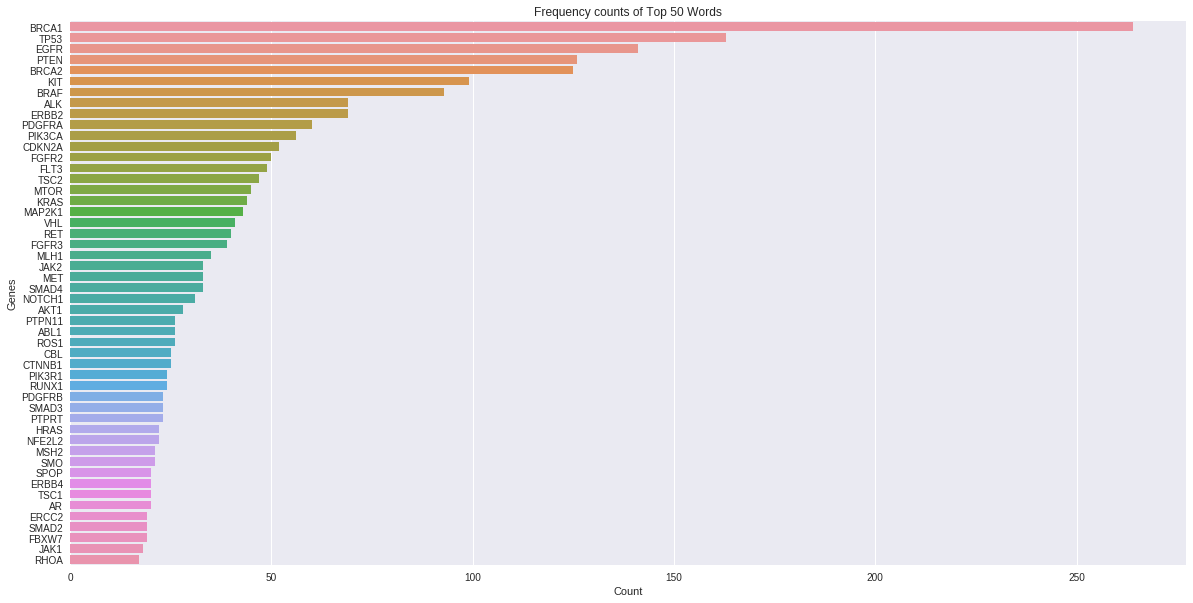

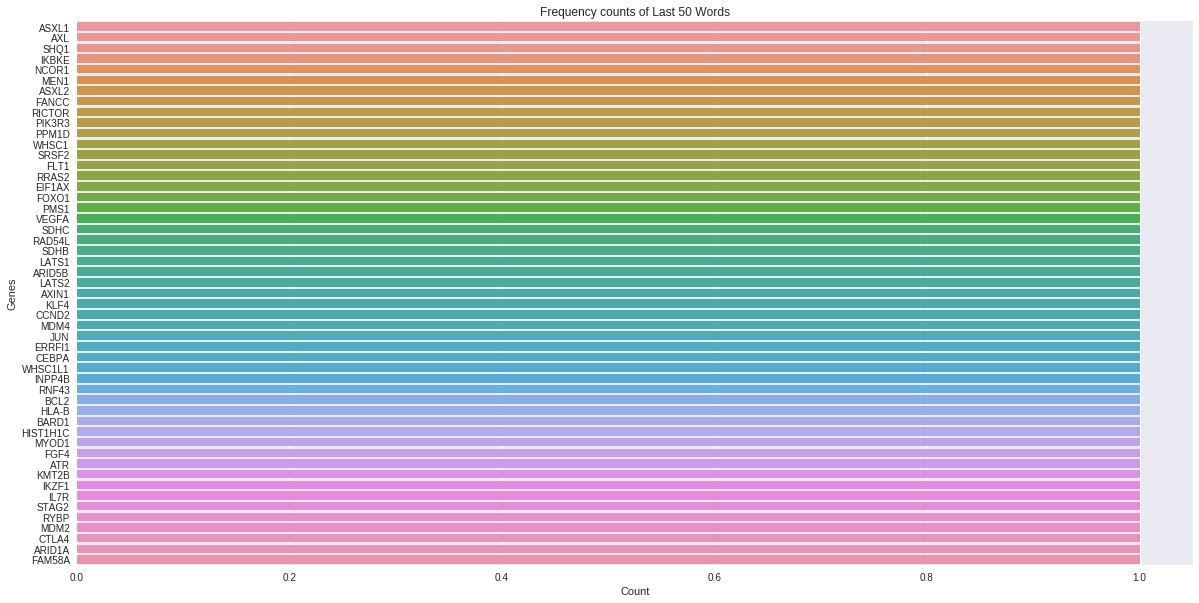

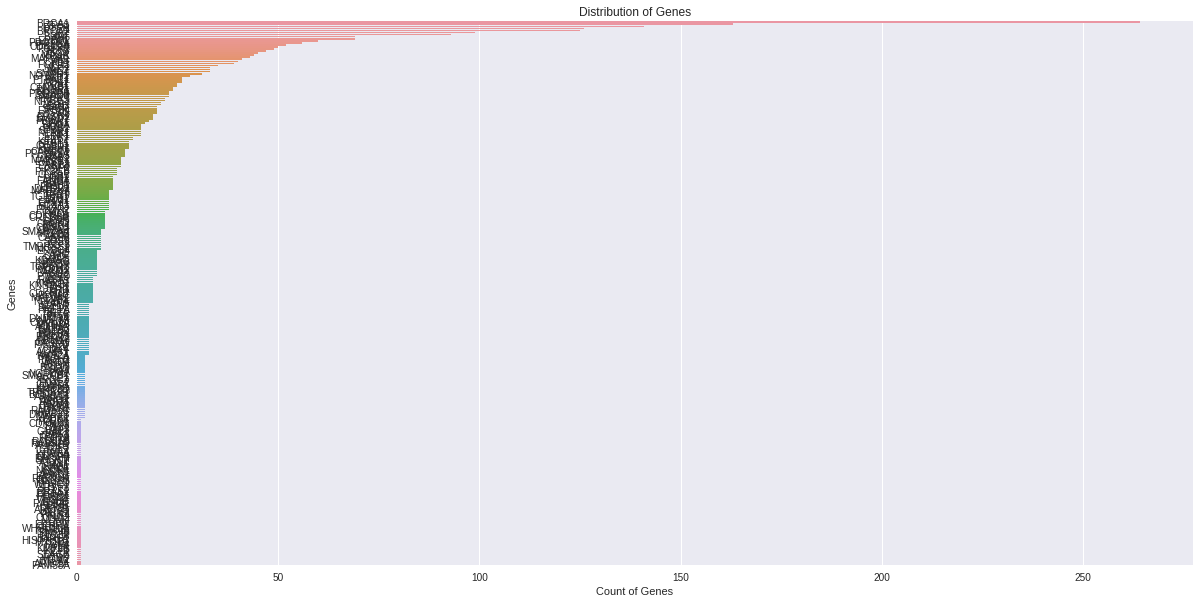

In [9]:
#Frequency count of Gene
print("Frequency count of values of Gene: \n")
count = collections.Counter(df_train["Gene"]) 
print(count)

freq = pd.DataFrame(list(count.items()), columns = ["Gene","Count"])
freq = freq.sort_values(by = "Count", ascending = False)

#Frequency count of top 50 words
plt.subplots(figsize = (20,10))
sns.barplot(x= "Count", y = "Gene", data = freq[0:50])
plt.title("Frequency counts of Top 50 Words")
plt.xlabel("Count")
plt.ylabel("Genes")
plt.show()

#Frequency count of last 50 words
plt.subplots(figsize = (20,10))
sns.barplot(x= "Count", y = "Gene", data = freq[213:264])
plt.title("Frequency counts of Last 50 Words")
plt.xlabel("Count")
plt.ylabel("Genes")
plt.show()

#Checking how the words are distributed as per their count
plt.subplots(figsize = (20,10))
sns.barplot(x= "Count", y = "Gene", data = freq)
plt.title("Distribution of Genes")
plt.xlabel("Count of Genes")
plt.ylabel("Genes")
plt.show()

In [10]:
#Count of Genes 

freq["Frequency_percent"] = (freq["Count"]/freq["Count"].sum())*100
freq.head(20)

,Gene,Count,Frequency_percent
213,BRCA1,264,7.949413
40,TP53,163,4.908160
22,EGFR,141,4.245709
196,PTEN,126,3.794038
215,BRCA2,125,3.763927
229,KIT,99,2.981030
214,BRAF,93,2.800361
119,ALK,69,2.077687
56,ERBB2,69,2.077687
68,PDGFRA,60,1.806685


##3.2) Univariate Anaysis: Variation

Frequency count of values of Variation: 

Counter({'Truncating Mutations': 93, 'Deletion': 74, 'Amplification': 71, 'Fusions': 34, 'Overexpression': 6, 'G12V': 4, 'Q61H': 3, 'Q61L': 3, 'T58I': 3, 'E17K': 3, 'Q61R': 3, 'Promoter Hypermethylation': 2, 'T286A': 2, 'E330K': 2, 'R841K': 2, 'TMPRSS2-ETV1 Fusion': 2, 'G35R': 2, 'S308A': 2, 'P130S': 2, 'G67R': 2, 'E542K': 2, 'R173C': 2, 'EWSR1-ETV1 Fusion': 2, 'ETV6-NTRK3 Fusion': 2, 'I31M': 2, 'G13D': 2, 'A146T': 2, 'G13V': 2, 'A146V': 2, 'Q61K': 2, 'K117N': 2, 'F28L': 2, 'G13C': 2, 'G12A': 2, 'Q22K': 2, 'G12S': 2, 'Y64A': 2, 'P34R': 2, 'G12C': 2, 'R170W': 2, 'F384L': 2, 'V321M': 2, 'T167A': 2, 'Y42C': 2, 'S222D': 2, 'T73I': 2, 'M1R': 2, 'C618R': 2, 'Q209L': 2, 'G12D': 2, 'W802*': 1, 'Q249E': 1, 'N454D': 1, 'L399V': 1, 'V391I': 1, 'V430M': 1, 'Y371H': 1, 'C384R': 1, 'P395A': 1, 'K382E': 1, 'R420Q': 1, 'C381A': 1, 'P428L': 1, 'D390Y': 1, 'Q367P': 1, 'M374V': 1, 'Y371S': 1, 'H94Y': 1, 'C396R': 1, 'G375P': 1, 'S376F': 1, 'P417A': 1, 'H398Y': 1, 

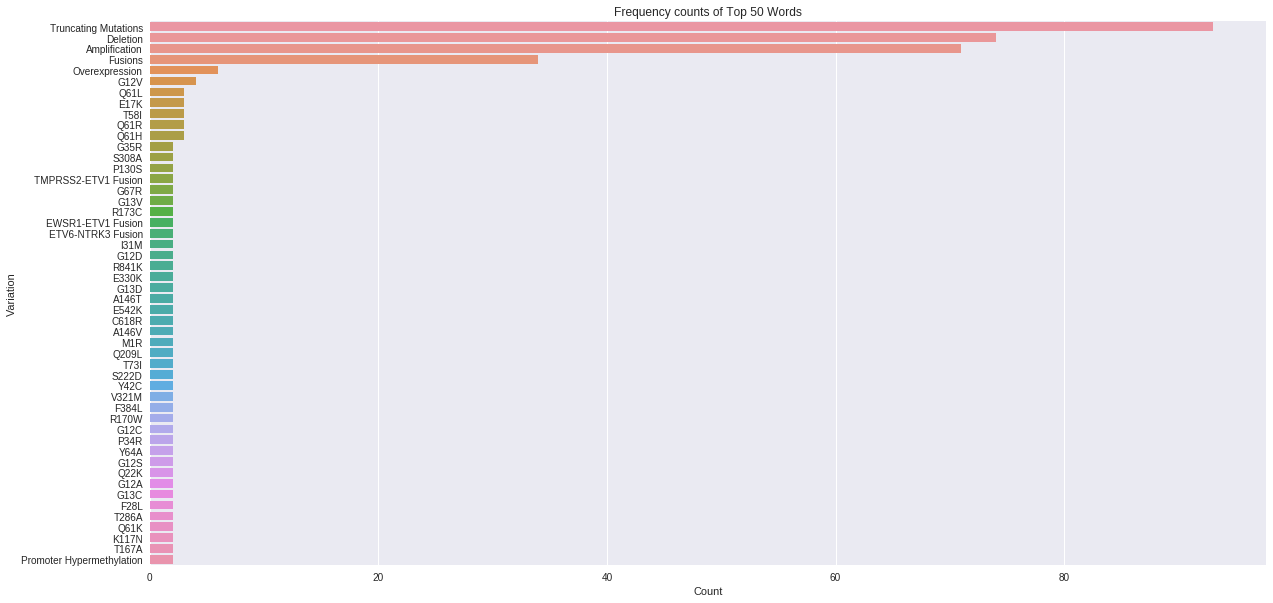

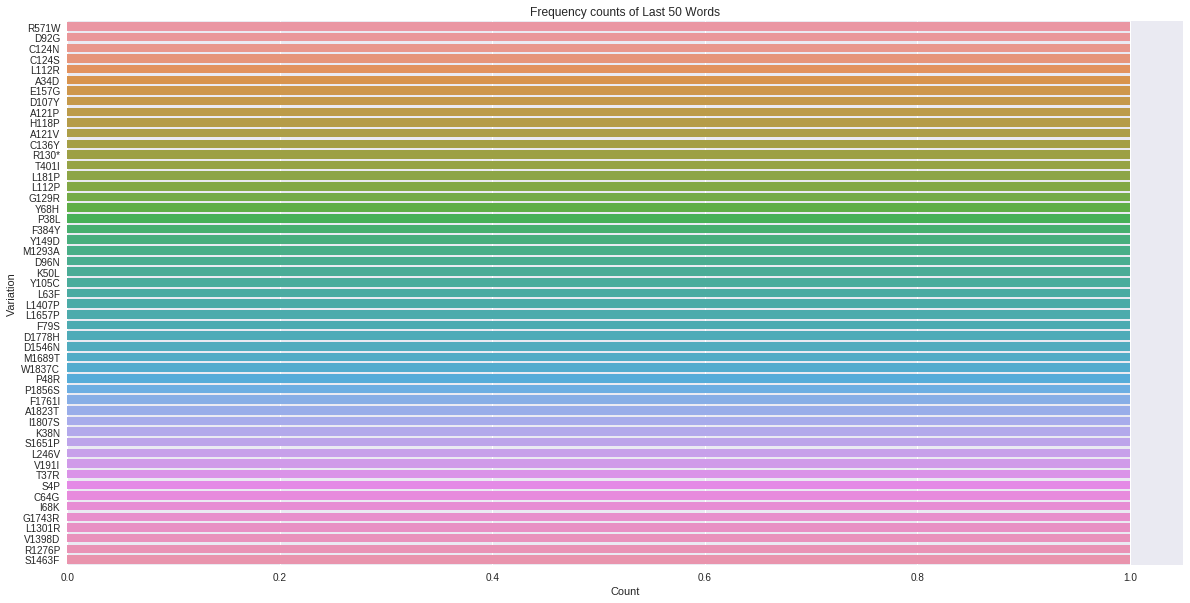

'\n#Checking how the words are distributed as per their count\nplt.subplots(figsize = (20,10))\nsns.barplot(x= "Count", y = "Variation", data = freq)\nplt.title("Distribution of Genes")\nplt.xlabel("Count of Variation")\nplt.ylabel("Variation")\nplt.show()\n'

In [11]:
#Frequency count of Variation
print("Frequency count of values of Variation: \n")
count = collections.Counter(df_train["Variation"]) 
print(count)

freq_var = pd.DataFrame(list(count.items()), columns = ["Variation","Count"])
freq_var = freq_var.sort_values(by = "Count", ascending = False)

#Frequency count of top 50 words
plt.subplots(figsize = (20,10))
sns.barplot(x= "Count", y = "Variation", data = freq_var[0:50])
plt.title("Frequency counts of Top 50 Words")
plt.xlabel("Count")
plt.ylabel("Variation")
plt.show()

#Frequency count of last 50 words
plt.subplots(figsize = (20,10))
sns.barplot(x= "Count", y = "Variation", data = freq_var[213:264])
plt.title("Frequency counts of Last 50 Words")
plt.xlabel("Count")
plt.ylabel("Variation")
plt.show()

'''
#Checking how the words are distributed as per their count
plt.subplots(figsize = (20,10))
sns.barplot(x= "Count", y = "Variation", data = freq)
plt.title("Distribution of Genes")
plt.xlabel("Count of Variation")
plt.ylabel("Variation")
plt.show()
'''

Text(0,0.5,'Count of Classes')

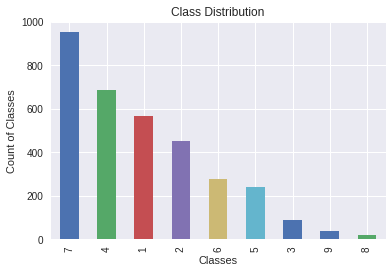

In [12]:
#Checking the distribution of Class for training dataset
class_dist = df_train["Class"].value_counts()
class_dist.plot(kind = 'bar')
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count of Classes")

In [0]:
#Function: Calculating the Length of Preprocessed text

def Length_text():

  #Adding "Length_text" column to the dataset and exploring the data

  #Calculating the Length of each text for train and test sets.
  #df_train["Text"].fillna(value = df_train["Gene"]+df_train["Variation"], inplace = True)

  Length_text = []
  for i in df_train["preprocessed_text"].values:
      Length_text.append(len(i.split()))

  df_train["Length_text"] = Length_text

  

  #Distribution of classes for their count of words
  plt.subplots(figsize = (20,10))
  sns.violinplot(x="Class", y = "Length_text", data = df_train)
  plt.show()


  print(" ")
  #Calculating the number of outliers for each class based on Text Length
  print("Number of outliers for each class:")
  print(" ")
  for i in range(1,10):
      j = df_train[df_train["Class"] == i]    
      print("Number of outliers for Class ",i," are: ",len(j[j["Length_text"]>20000]))

In [0]:
#Function: To construct a Word Cloud

def word_cloud():

  #Constructing wordcloud
  wordcloud = WordCloud(height = 500, width = 500).generate(str(df_train["preprocessed_text"]))

  plt.figure(figsize = (8,8))
  plt.axis("off")
  plt.imshow(wordcloud)

#4) Data Preprocessing

In [15]:
#Replacing NaN values with null

df_train["Text"] = df_train["Text"].fillna(value = "null")
df_test["Text"] = df_test["Text"].fillna(value = "null")

#Chechking for anymore NaN values
df_train[df_train["Text"].isnull()]

#Calling function: Length_text , to explore "Length_text" column.
#Length_text()

,ID,Gene,Variation,Class,Text


In [16]:
#Function: for Text Preprocessing

length = []
final_sen = []
#stemmer = PorterStemmer()
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')              #Downloading the stopwords
sw = set(stopwords.words("english"))

def text_preprocessing():
  
  def html_parser(data):
    html = re.sub(r'<.*?>'," ",data)
    return html
  
  def punctuations(data):
    punc = re.sub(r'[?|!|@|#|$|%|\'|\"|_|,|.|;|:|-|(|)|\|/|+|-|>|<|-]'," ", data)
    punc = re.sub('[^a-zA-Z0-9\n]', ' ', punc)
    punc = re.sub('\s+',' ', punc)
    return punc
  
  for i in df_train["Text"].values:
    sen_html = html_parser(i)
    sen_punc = punctuations(sen_html)
    words = []
    for word in sen_punc.split():
      if((word.lower()).isalnum() and word.lower() not in sw):
        word = lemmatizer.lemmatize(word)
        #word = stemmer.stem(word)
        words.append(word.lower())
    sen = " ".join(words)    
    final_sen.append(sen)  
   

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#Calling the Text preprocessing function

text_preprocessing()
df_train["preprocessed_text"] = final_sen

#Calling function: Length_text , to explore "Length_text" column.
Length_text()

In [19]:
df_train.head()

,ID,Gene,Variation,Class,Text,preprocessed_text,Length_text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinase cdks regulate variety ...,4370
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...,4139
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...,4139
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,recent evidence demonstrated acquired uniparen...,3181
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutation monomeric casitas b lineage...,4254


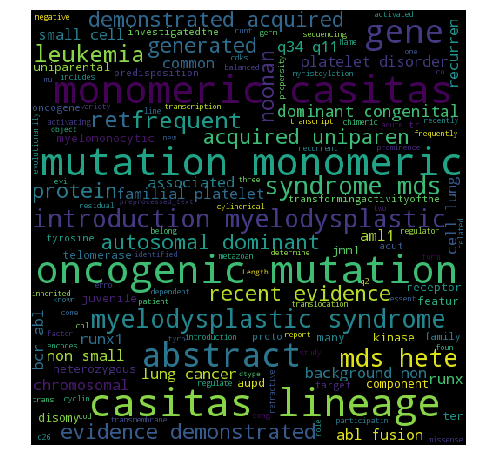

In [20]:
#Constructing a word cloud of most used words
word_cloud()


In [21]:
#Vectorizing the text data using Tfidf Vectorizer.

vect = TfidfVectorizer(ngram_range = (1,3), max_features = 50000, min_df = 5)
df_x = vect.fit_transform(df_train["Text"].values)
#indices = np.argsort(vect.idf_)[::-1]
features = vect.get_feature_names()


df_x.shape

(3321, 50000)

In [22]:
# Using SVD technique to compress the number of columns of the dataset to 750.

SVD = TruncatedSVD(n_components = 750, n_iter = 7, random_state = 42)
svd = SVD.fit_transform(df_x)

SVD_text = pd.DataFrame(svd)

SVD_text["ID"] = df_train["ID"]


SVD_text.shape

(3321, 751)

In [23]:
df_train.head()

,ID,Gene,Variation,Class,Text,preprocessed_text,Length_text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,cyclin dependent kinase cdks regulate variety ...,4370
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...,4139
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,abstract background non small cell lung cancer...,4139
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,recent evidence demonstrated acquired uniparen...,3181
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,oncogenic mutation monomeric casitas b lineage...,4254


#5) Modelling

##5.1) Data Preprocessing before modelling

In [0]:
#Dropping of Class Label from Training Dataset
y = df_train["Class"].values
df_train.drop("Class", axis = 1, inplace = True)


#train-test split
X_train, X_test, y_train, y_test = train_test_split(df_train,y, train_size = 0.8, random_state = 42, stratify = y)
#Train-cv split
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train, y_train, train_size = 0.8, random_state = 42, stratify = y_train)

In [0]:
#Function: Plotting Confusion Matrix, Precision Matrix, Recall Matrix and calculaing Misclassification rate of Test dataset 

def plot_confusion_matrix(y_true, y_pred):
  C = confusion_matrix(y_true, y_pred)
  
  #Recall
  A = (((C.T)/C.sum(axis = 1)).T)
  
  #Precision
  B = (C/C.sum(axis = 0))
  
  Class = [1,2,3,4,5,6,7,8,9]
  #Confusion Matrix
  print("--------------------Confusion Matrix------------------")
  plt.figure(figsize = (20,7))
  sns.heatmap(data = C, annot = True, cmap= "YlGnBu", fmt = "0.3f", xticklabels = Class, yticklabels = Class)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.show()
  
  #Precision heat map
  print("-------------------Precision Heatmap--------------------")
  plt.figure(figsize = (20,7))
  sns.heatmap(data = B, annot = True, cmap= "YlGnBu", fmt = "0.3f", xticklabels = Class, yticklabels = Class)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.show()
  
  #Recall heatmap
  print("--------------------------Recall Heatmap--------------------------")
  plt.figure(figsize = (20,7))
  sns.heatmap(data = A, annot = True, cmap= "YlGnBu", fmt = "0.3f", xticklabels = Class, yticklabels = Class)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Class")
  plt.show()
  
  
  count = 0
  #Misclassification Rate
  for i in range(len(y_true)):
    if (y_true[i]-y_pred[i] != 0):
      count = count+1
    else:
      continue
    
  print("Misclassification Rate: ", (count/len(y_true))*100,"%")

##5.2) Random Modelling

In [27]:
# ----------------------------------------------Randomly assigning probablities to the variable.----------------------------------------
'''
      #Another way to assign Random probablities:

      ll = np.zeros((200,9))
      for i in range(0,200):
        for j in range(0,9):
          ll[i][j] = np.random.randint(0,10)

      for i in range(0,200):
        a = np.sum(ll[i], axis=0)
        for j in range(0,9):
          ll[i][j] = np.round(ll[i][j]/a , 3)
'''

#Constructing Random Probablities for X_tr
prob_tr = np.zeros((len(X_tr),9))
for i in range(len(X_tr)):
  s = np.random.rand(1,9)
  #print(s)
  prob_tr[i] = ((s/s.sum()))
  
  
#Constructing Random Probablities for X_cv
prob_cv = np.zeros((len(X_cv),9))
for i in range(len(X_cv)):
  s = np.random.rand(1,9)
  #print(s)
  prob_cv[i] = ((s/s.sum()))
  
  
#Constructing Random Probablities for X_test
prob_test = np.zeros((len(X_test),9))
for i in range(len(X_test)):
  s = np.random.rand(1,9)
  #print(s)
  prob_test[i] = ((s/s.sum()))
  
  
  
loss_tr = log_loss(y_tr, prob_tr)
loss_cv = log_loss(y_cv, prob_cv)
loss_test = log_loss(y_test, prob_test)

print("The log loss for Training Random Model is: ", format(loss_tr))
print("The Log Loss for Cross Validation Random Model is: ", format(loss_cv))
print("The Log Loss for Testing Random Model is : ", format(loss_test))

#predict_and_plot_confusion_matrix(y_test, prob_test)

The log loss for Training Random Model is:  2.468896285367777
The Log Loss for Cross Validation Random Model is:  2.4450408116029223
The Log Loss for Testing Random Model is :  2.485758943666451


##5.3) Univariate Modelling: Gene

Log Loss for alpha = 1e-05  is:  1.3772098858143802
Log Loss for alpha = 0.0001  is:  1.1789310520107945
Log Loss for alpha = 0.001  is:  1.2024164691578665
Log Loss for alpha = 0.01  is:  1.3402854712494154
Log Loss for alpha = 0.1  is:  1.4400087870195823
Log Loss for alpha = 1  is:  1.4694962231268212
Log Loss for alpha = 10  is:  1.47363710304994
Log Loss for alpha = 100  is:  1.474136174984171
Log Loss for alpha = 1000  is:  1.4742294218698728
 
The best alpha is:  0.0001
Log loss for alpha:  0.0001  for Training set is:  1.0221832343369401
Log Loss for alpha = 0.0001 for CV set is:  1.1789310520107945
Log Loss for alpha = 0.0001 for Test set is:  1.2575410397098312
--------------------Confusion Matrix------------------


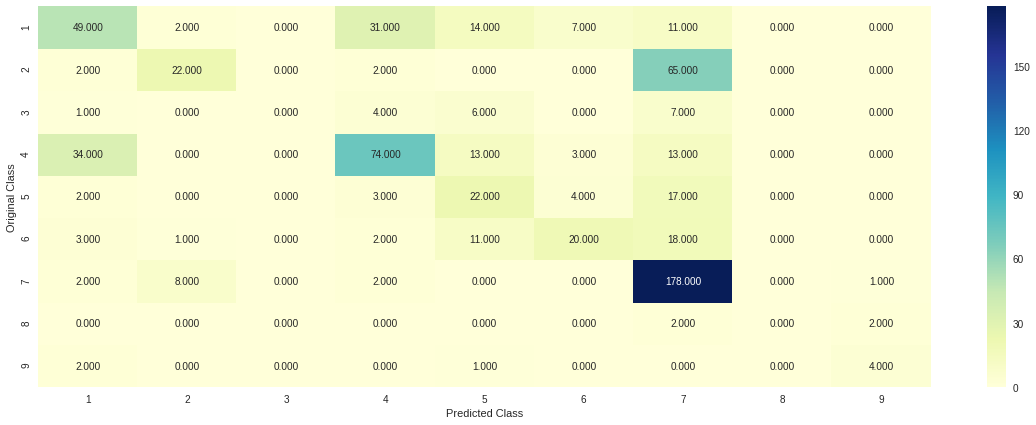

-------------------Precision Heatmap--------------------


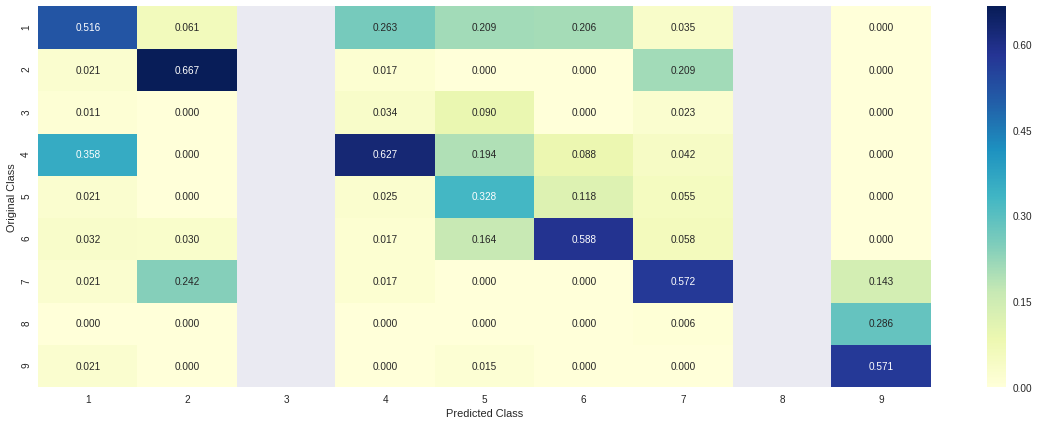

--------------------------Recall Heatmap--------------------------


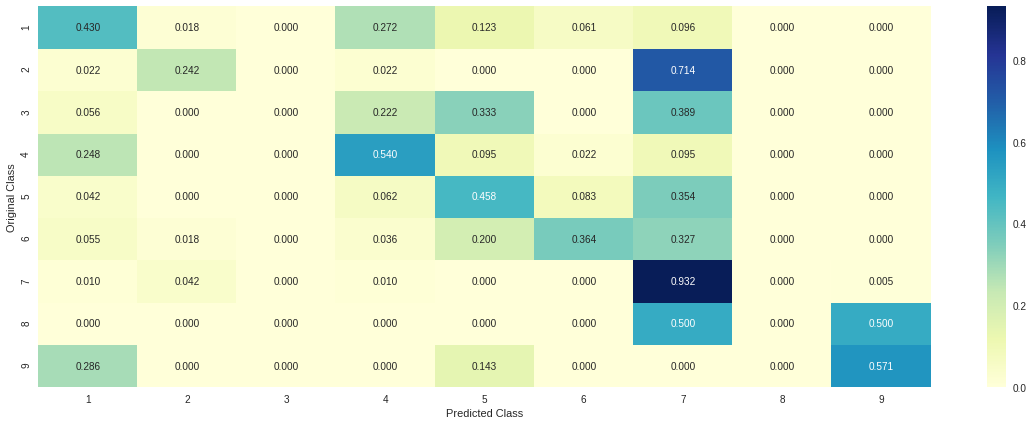

Misclassification Rate:  44.51127819548872 %


In [28]:

#----------------------------------Modelling using one Feature: Gene---------------------------------------

#Converting Categorical Gene Feature into numerical form using One Hot Encoding.

#Converting Gene feature.
tfidf_vect = TfidfVectorizer()
gene_sparse_tr = tfidf_vect.fit_transform(X_tr["Gene"])                       
gene_sparse_cv = tfidf_vect.transform(X_cv["Gene"])
gene_sparse_test = tfidf_vect.transform(X_test["Gene"])



alpha_range = [0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]

#Using Logistic Regression as a model
logloss = []
for alpha in alpha_range: 
  clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
  LR = clf.fit(gene_sparse_tr, y_tr)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(gene_sparse_tr, y_tr)
  predict_probablity = sig_clf.predict_proba(gene_sparse_cv)
  loss = log_loss(y_cv,predict_probablity)
  logloss.append(loss)
  print("Log Loss for alpha =",alpha, " is: ", loss )
  
print(" ")
best_alpha = alpha_range[np.argmin(logloss)]
print("The best alpha is: ",best_alpha)

#Use the best_alpha, to find log loss for Training, CV and Test dataset. 
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
LR = clf.fit(gene_sparse_tr, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(gene_sparse_tr, y_tr)

#Logloss for Training set
predict_probablity_train = sig_clf.predict_proba(gene_sparse_tr)
loss_train = log_loss(y_tr, predict_probablity_train)
print("Log loss for alpha: ",best_alpha, " for Training set is: ", loss_train)

#Logloss for CV set
predict_probablity_cv = sig_clf.predict_proba(gene_sparse_cv)
loss_cv = log_loss(y_cv,predict_probablity_cv)
print("Log Loss for alpha =",best_alpha, "for CV set is: ",loss_cv)

#Logloss for Test set
predict_probablity_test = sig_clf.predict_proba(gene_sparse_test)
predict = sig_clf.predict(gene_sparse_test)
loss_test = log_loss(y_test, predict_probablity_test)
print("Log Loss for alpha =",best_alpha, "for Test set is: ", loss_test)

plot_confusion_matrix(y_test, predict)

##5.4) Univariate Modelling: Variation

Log Loss for alpha = 1e-05  is:  1.694476301283199
Log Loss for alpha = 0.0001  is:  1.688488191242964
Log Loss for alpha = 0.001  is:  1.6896254672676236
Log Loss for alpha = 0.01  is:  1.688595005813492
Log Loss for alpha = 0.1  is:  1.7000152955227446
Log Loss for alpha = 1  is:  1.7010721187280724
Log Loss for alpha = 10  is:  1.7011983940013173
Log Loss for alpha = 100  is:  1.7012649415427035
Log Loss for alpha = 1000  is:  1.7029223077741775
 
The best alpha is:  0.0001
Log loss for alpha:  0.0001  for Training set is:  0.7763002862299588
Log Loss for alpha = 0.0001 for CV set is:  1.7029223077741775
Log Loss for alpha = 0.0001 for Test set is:  1.7238934681679805
--------------------Confusion Matrix------------------


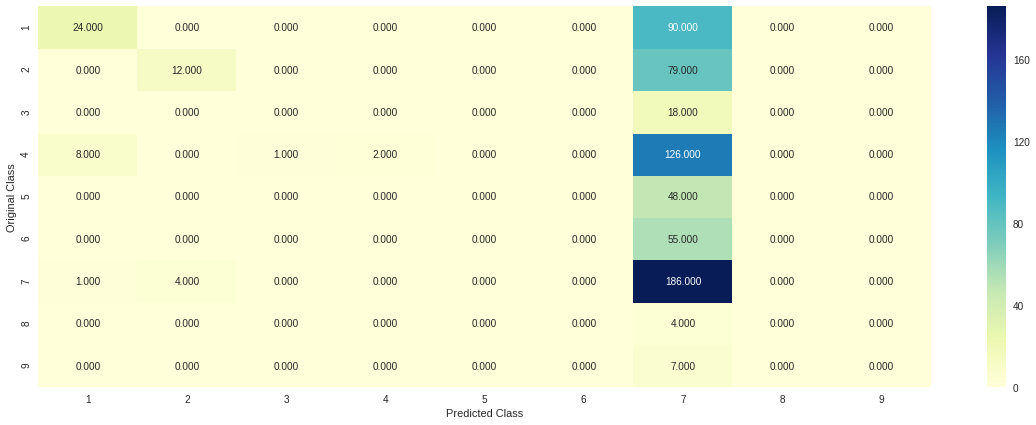

-------------------Precision Heatmap--------------------


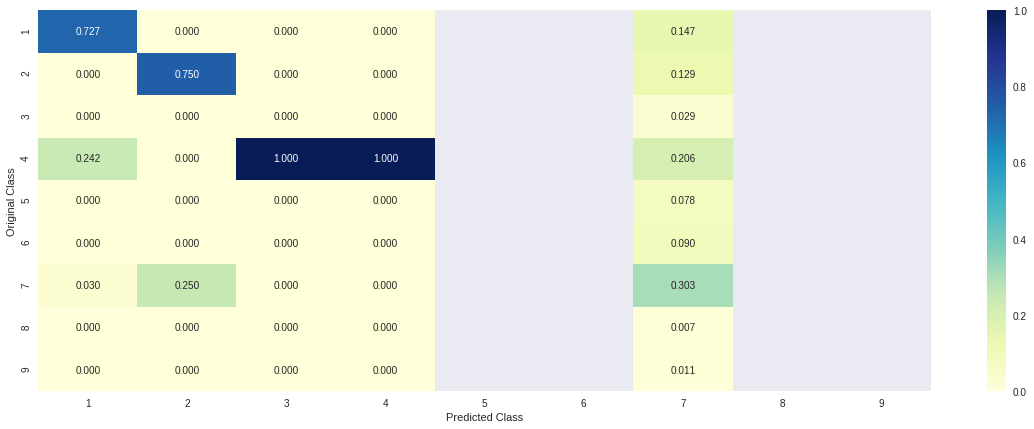

--------------------------Recall Heatmap--------------------------


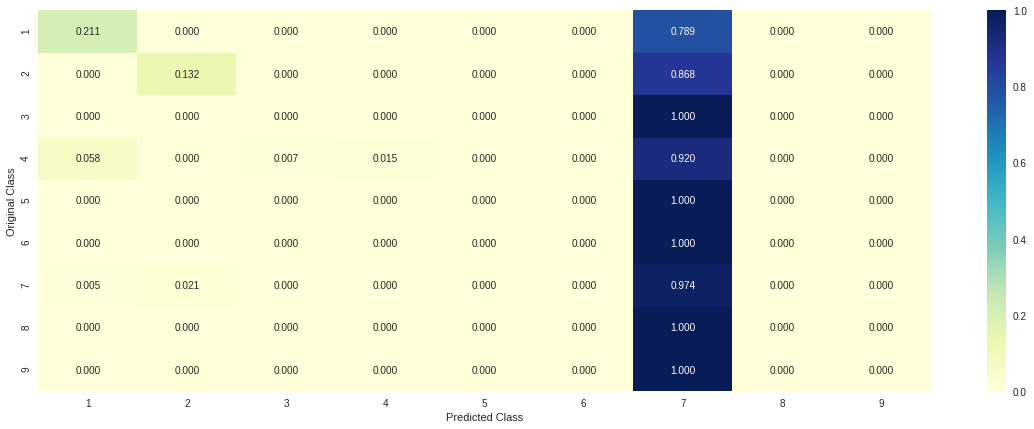

Misclassification Rate:  66.3157894736842 %


In [29]:

#----------------------------------Modelling using one Feature: Variations---------------------------------------

#Converting Categorical Variation Feature into numerical form using One Tf-Idf Vectorizer.

#Converting Gene feature.
tfidf_vect = TfidfVectorizer()
var_sparse_tr = tfidf_vect.fit_transform(X_tr["Variation"])                       
var_sparse_cv = tfidf_vect.transform(X_cv["Variation"])
var_sparse_test = tfidf_vect.transform(X_test["Variation"])


#Using Naive Bayes as a Baseline model
alpha_range = [0.00001, 0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]

#Using Logistic Regression as a model
logloss = []
for alpha in alpha_range: 
  clf = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
  LR = clf.fit(var_sparse_tr, y_tr)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf_1 = sig_clf.fit(var_sparse_tr, y_tr)
  predict_probablity = sig_clf_1.predict_proba(var_sparse_cv)
  loss = log_loss(y_cv,predict_probablity)
  logloss.append(loss)
  print("Log Loss for alpha =",alpha, " is: ", loss )
  
print(" ")
best_alpha = alpha_range[np.argmin(logloss)]
print("The best alpha is: ",best_alpha)

#Use the best_alpha, to find log loss for Training, CV and Test dataset.  
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
LR = clf.fit(gene_sparse_tr, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(var_sparse_tr, y_tr)

#Logloss for Training set
predict_probablity_train = sig_clf.predict_proba(var_sparse_tr)
loss_train = log_loss(y_tr, predict_probablity_train)
print("Log loss for alpha: ",best_alpha, " for Training set is: ", loss_train)

#Logloss for CV set
predict_probablity_cv = sig_clf.predict_proba(var_sparse_cv)
loss_cv = log_loss(y_cv,predict_probablity)
print("Log Loss for alpha =",best_alpha, "for CV set is: ",loss_cv)

#Logloss for Test set
predict = sig_clf.predict(var_sparse_test)
predict_probablity_test = sig_clf.predict_proba(var_sparse_test)
loss_test = log_loss(y_test, predict_probablity_test)
print("Log Loss for alpha =",best_alpha, "for Test set is: ", loss_test)

plot_confusion_matrix(y_test, predict)

##5.5) Univariate Modelling: Text

Log loss for alpha =  1e-05  is:  1.0645562084185944
Log loss for alpha =  0.0001  is:  1.0145471952195833
Log loss for alpha =  0.001  is:  1.153671542075059
Log loss for alpha =  0.01  is:  1.4925263475481796
Log loss for alpha =  0.1  is:  1.7686825857752524
Log loss for alpha =  1  is:  1.798417789414148
Log loss for alpha =  10  is:  1.800818183946502
Log loss for alpha =  100  is:  1.8010705565598188
 
best alpha: 0.0001
Log loss for Train set with alpha:  0.0001  is:  0.6992401396820194
Log loss for CV set with alpha:  0.0001  is:  1.0169280728916306
Log loss for Test set with alpha:  0.0001  is:  1.1431793554603835
--------------------Confusion Matrix------------------


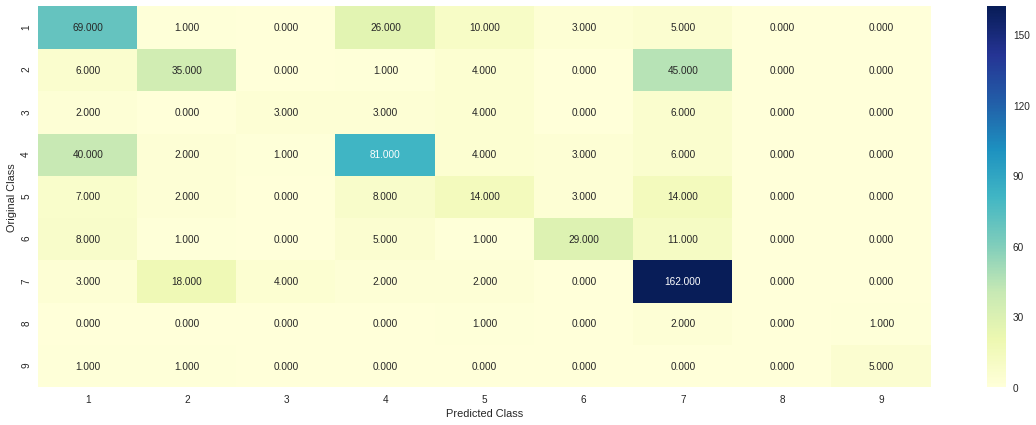

-------------------Precision Heatmap--------------------


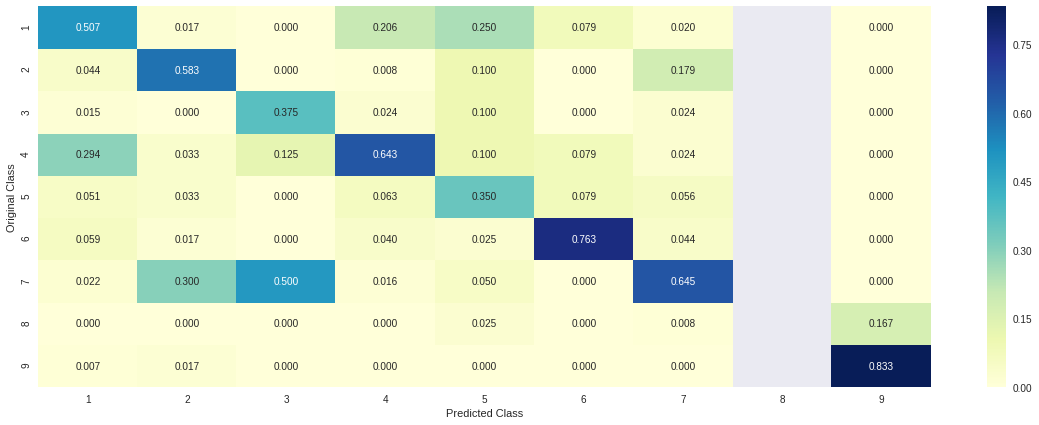

--------------------------Recall Heatmap--------------------------


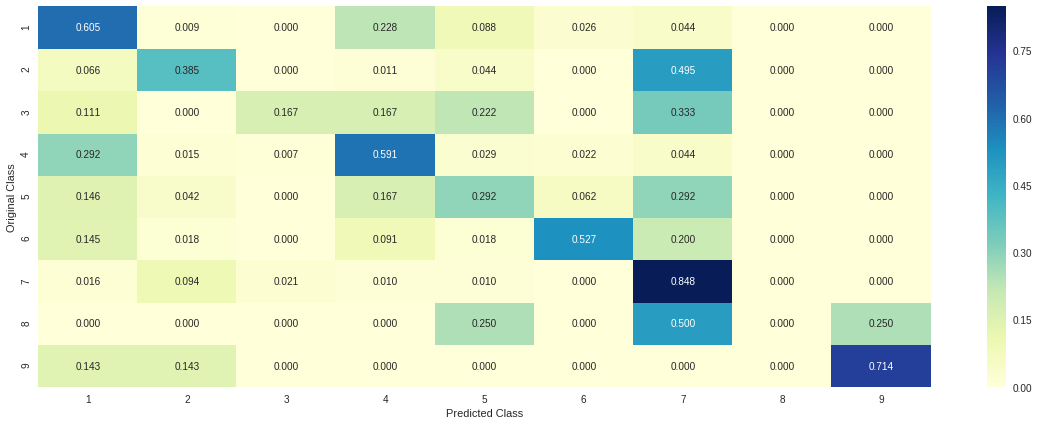

Misclassification Rate:  40.150375939849624 %


In [30]:
#---------------------Modelling using one feature: Text------------------------

#Creating a sparse matrix for text feature

tfidf = TfidfVectorizer()
text_sparse_tr = tfidf.fit_transform(X_tr["Text"])
text_sparse_cv = tfidf.transform(X_cv["Text"])
text_sparse_test = tfidf.transform(X_test["Text"])

alpha_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

#Using Logistic Regression as a model
logloss = []
for alpha in alpha_range:
  clf = SGDClassifier(alpha = alpha, penalty = "l2", loss = "log", random_state = 42)
  naive_fit  = clf.fit(text_sparse_tr, y_tr)
  sig_clf = CalibratedClassifierCV(naive_fit, method="sigmoid")
  sig_clf_1 = sig_clf.fit(text_sparse_tr, y_tr)
  predict_probablity = sig_clf_1.predict_proba(text_sparse_cv)
  loss = log_loss(y_true = y_cv, y_pred = predict_probablity)
  logloss.append(loss)
  print("Log loss for alpha = ",alpha," is: ",loss)
  
  
best_alpha = alpha_range[np.argmin(logloss)]

clf = SGDClassifier(alpha = best_alpha, penalty = "l2", loss = "log")
naive_fit = clf.fit(text_sparse_tr, y_tr)
sig_clf = CalibratedClassifierCV(naive_fit, method = "sigmoid")
sig_clf_1 = sig_clf.fit(text_sparse_tr, y_tr)

predict_probablity_train = sig_clf_1.predict_proba(text_sparse_tr)
loss_train = log_loss(y_true = y_tr, y_pred = predict_probablity_train)

predict_probablity_cv = sig_clf_1.predict_proba(text_sparse_cv)
loss_cv = log_loss(y_true = y_cv, y_pred = predict_probablity_cv)

predict_probablity_test = sig_clf_1.predict_proba(text_sparse_test)
loss_test = log_loss(y_true = y_test, y_pred = predict_probablity_test)

print(" ")
print("best alpha:", best_alpha)
print("Log loss for Train set with alpha: ", best_alpha," is: ",loss_train)
print("Log loss for CV set with alpha: ", best_alpha," is: ",loss_cv)
print("Log loss for Test set with alpha: ", best_alpha," is: ",loss_test)

predict = sig_clf.predict(text_sparse_test)
plot_confusion_matrix(y_test, predict)

##5.6) Modelling: Data Preprocessing

In [0]:
#--------------------Preperation for Modelling------------------------

#Horizontal Stacking of Gene, Variation, and Text data for Train, CV, Test dataset.

df_inter = sc.sparse.hstack((gene_sparse_tr, var_sparse_tr))
df_tr = sc.sparse.hstack((df_inter, text_sparse_tr))

df_inter = sc.sparse.hstack((gene_sparse_cv, var_sparse_cv))
df_cv = sc.sparse.hstack((df_inter, text_sparse_cv))

df_inter = sc.sparse.hstack((gene_sparse_test, var_sparse_test))
df_test = sc.sparse.hstack((df_inter, text_sparse_test))

In [0]:
#Concatinating "Gene", "Variation" and SVD_text features into a single dataframe.

gene = pd.get_dummies(df_train["Gene"].values)
variation = pd.get_dummies(df_train["Variation"].values)
dummy1 = pd.concat([gene,variation], axis = 1)
dummy2 = pd.concat([dummy1, SVD_text], axis = 1)
dummy2.drop("ID", axis = 1, inplace = True)


#train-test split
X_train, X_test, y_train, y_test = train_test_split(dummy2,y, train_size = 0.8, random_state = 42, stratify = y)
#Train-cv split
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train, y_train, train_size = 0.8, random_state = 42, stratify = y_train)

In [33]:
X_tr.head()

,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,740,741,742,743,744,745,746,747,748,749
988,0,0,0,0,0,0,0,0,0,0,...,-0.000840,0.006533,0.003515,-0.000921,0.009257,-0.001447,-0.010189,-0.010419,-0.008119,-0.007286
3319,0,0,0,0,0,0,0,0,0,0,...,0.004465,0.014176,-0.007479,-0.014553,-0.015491,-0.006161,-0.001109,0.001887,0.012312,0.001665
528,0,0,0,0,0,0,0,0,0,0,...,0.000673,0.002048,0.000992,-0.000399,-0.003344,-0.002287,0.002288,0.002909,-0.001262,-0.002238
1520,0,0,0,0,0,0,1,0,0,0,...,-0.006456,-0.006016,0.005400,0.010651,0.002041,-0.000781,-0.005857,0.007267,-0.004998,0.004623
1787,0,0,0,0,0,0,0,0,1,0,...,-0.000902,-0.000643,0.000607,-0.000005,0.001198,-0.001096,0.000541,0.000382,0.000716,0.000140


##5.7) Modelling: Naive Bayes

Logloss for alpha: 1e-05  is:  1.1475963351323593
Logloss for alpha: 0.0001  is:  1.1520118131824273
Logloss for alpha: 0.001  is:  1.142607591997169
Logloss for alpha: 0.1  is:  1.2407037565041554
Logloss for alpha: 1  is:  1.2797688512844678
Logloss for alpha: 10  is:  1.3034673023150358
Logloss for alpha: 100  is:  1.3683259300969814
Logloss for alpha: 1000  is:  1.407528189935178
 
Log loss for alpha : 0.001  and Training set is: 0.6043458447083163
Log loss for alpha : 0.001  and Cross Validation set is: 1.142607591997169
Log loss for alpha : 0.001  and Training set is: 1.264473023825505
--------------------Confusion Matrix------------------


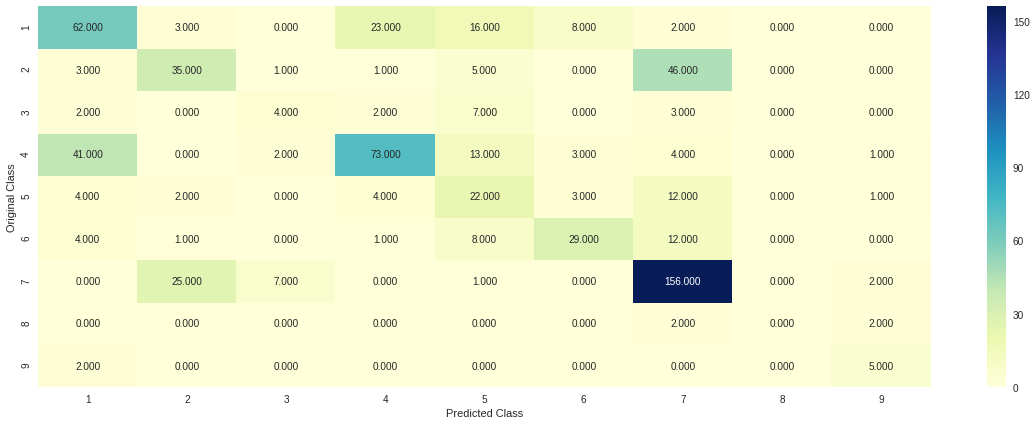

-------------------Precision Heatmap--------------------


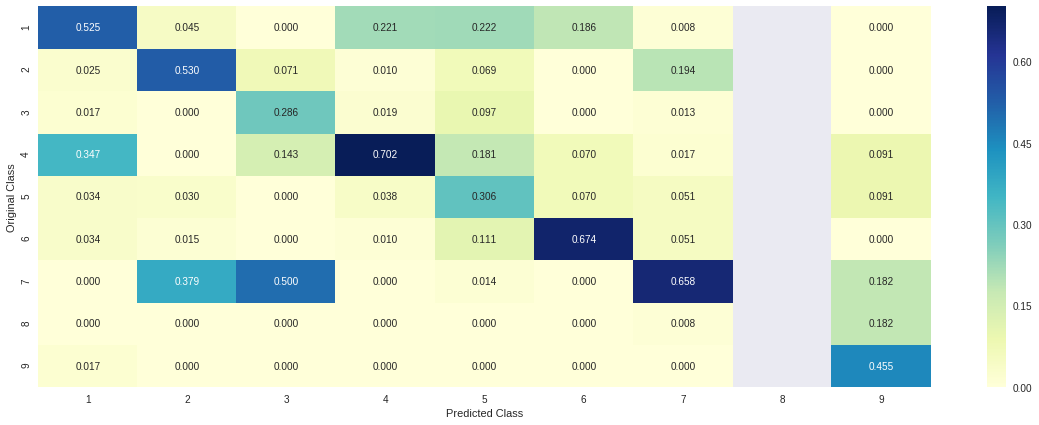

--------------------------Recall Heatmap--------------------------


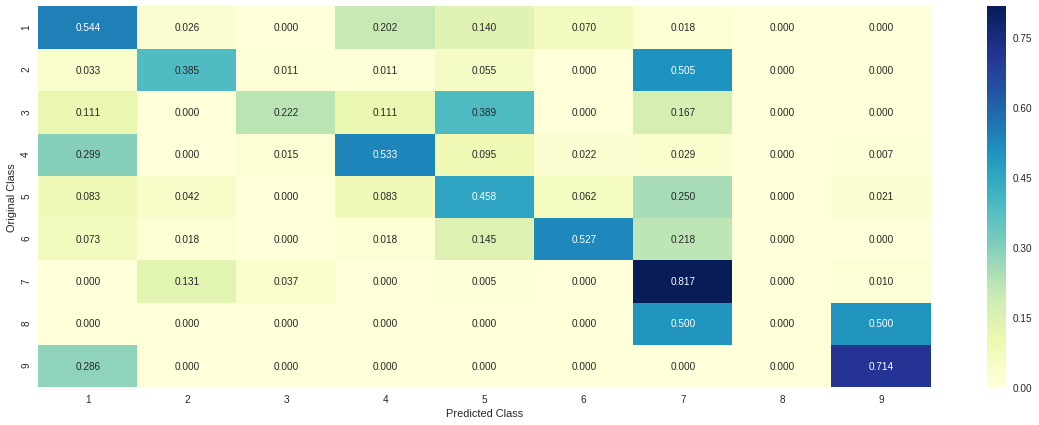

Misclassification Rate:  41.95488721804511 %


In [34]:
#-------------------------Modelling with Multinomial Naive Bayes Algorithm-----------------------------

k_range = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
logloss = []
for k in k_range:
  NB = MultinomialNB(alpha = k)
  NB.fit(df_tr,y_tr)
  sig_clf = CalibratedClassifierCV(NB, method="sigmoid")
  sig_clf.fit(df_tr, y_tr)
  prediction = sig_clf.predict_proba(df_cv)
  loss = log_loss(y_true = y_cv, y_pred = prediction)
  logloss.append(loss)
  print("Logloss for alpha:",k, " is: ",loss)
  
  
best_k = k_range[np.argmin(logloss)]

NB = MultinomialNB(alpha = best_k)
NB.fit(df_tr, y_tr)
sig_clf = CalibratedClassifierCV(NB, method = "sigmoid")
sig_clf.fit(df_tr, y_tr)
#prediction = sig_clf.predict_proba(df_cv)
#loss = log_loss(y_true = y_cv, y_pred = prediction)

print(" ")
prediction_tr = sig_clf.predict_proba(df_tr)
print("Log loss for alpha :",best_k, " and Training set is:", log_loss(y_true = y_tr, y_pred = prediction_tr))

prediction_cv = sig_clf.predict_proba(df_cv)
print("Log loss for alpha :",best_k, " and Cross Validation set is:", log_loss(y_true = y_cv, y_pred = prediction_cv))

prediction_test = sig_clf.predict_proba(df_test)
print("Log loss for alpha :",best_k, " and Training set is:", log_loss(y_true = y_test, y_pred = prediction_test))

predict = sig_clf.predict(df_test)
plot_confusion_matrix(y_test, predict)


##5.8) Modelling: Logistic Regression with class balancing

Logloss for alpha: 1e-06  is:  1.193154650806745
Logloss for alpha: 1e-05  is:  1.1931153794510108
Logloss for alpha: 0.0001  is:  1.1926632834406394
Logloss for alpha: 0.001  is:  1.1896049928024914
Logloss for alpha: 0.01  is:  1.1651210456502816
Logloss for alpha: 0.1  is:  1.0753184396473487
Logloss for alpha: 1  is:  0.9810427760260919
Logloss for alpha: 10  is:  0.932085093069428
Logloss for alpha: 100  is:  0.9432429935918539
Logloss for alpha: 1000  is:  0.9416173673076598
 
Log loss for alpha : 10  and Training set is: 0.41197837117707214
Log loss for alpha : 10  and Cross Validation set is: 0.9384521083474641
Log loss for alpha : 10  and Training set is: 1.060640385135292
--------------------Confusion Matrix------------------


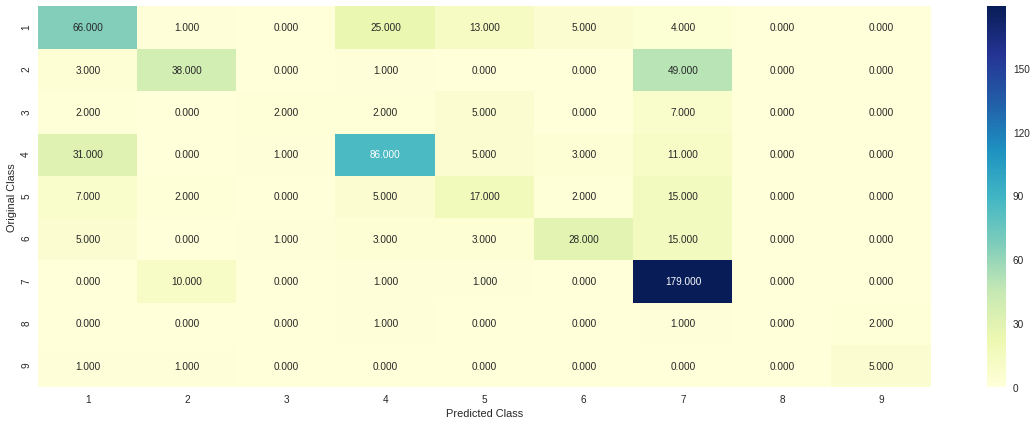

-------------------Precision Heatmap--------------------


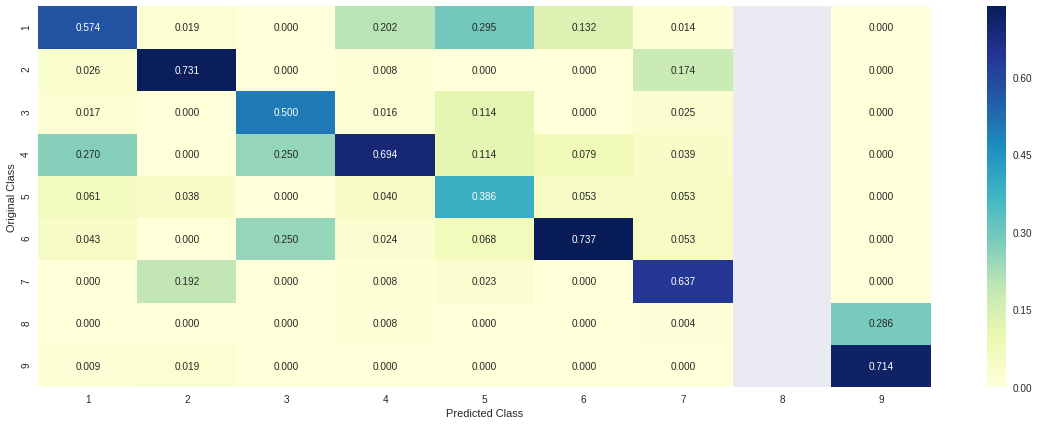

--------------------------Recall Heatmap--------------------------


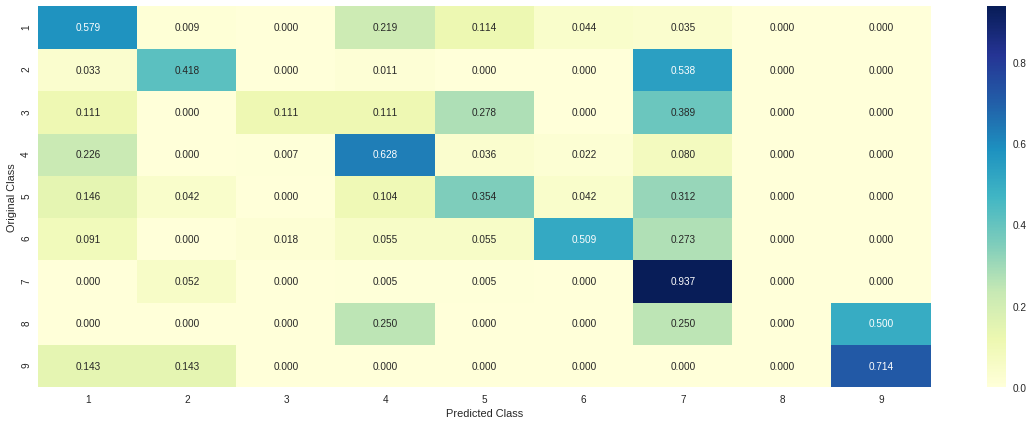

Misclassification Rate:  36.69172932330827 %


In [35]:
#-------------------------Modelling with Logistic Regression---------------------------

alpha_range = [0.000001,0.00001,0.0001,0.001,0.01, 0.1,1,10,100,1000]
logloss = []
for alpha in alpha_range:
  #LR = SGDClassifier(alpha = alpha, penalty = "l2", loss = "log", random_state = 42)
  LR = LogisticRegression(C = alpha, class_weight = "balanced", penalty = "l2", solver = "saga")
  LR.fit(X_tr,y_tr)
  sig_clf = CalibratedClassifierCV(LR, method="sigmoid")
  sig_clf.fit(X_tr, y_tr)
  prediction = sig_clf.predict_proba(X_cv)
  loss = log_loss(y_true = y_cv, y_pred = prediction)
  logloss.append(loss)
  print("Logloss for alpha:",alpha, " is: ",loss)
  
  
best_alpha = alpha_range[np.argmin(logloss)]

#LR = SGDClassifier(alpha = best_alpha, penalty = "l2", loss = "log", random_state = 42)
LR = LogisticRegression(C = best_alpha, class_weight = "balanced", penalty = "l2", solver = "saga")
LR.fit(X_tr, y_tr)
sig_clf = CalibratedClassifierCV(LR, method = "sigmoid")
sig_clf.fit(X_tr, y_tr)
#prediction = sig_clf.predict_proba(df_cv)
#loss = log_loss(y_true = y_cv, y_pred = prediction)

print(" ")
prediction_tr = sig_clf.predict_proba(X_tr)
print("Log loss for alpha :",best_alpha ," and Training set is:", log_loss(y_true = y_tr, y_pred = prediction_tr))

prediction_cv = sig_clf.predict_proba(X_cv)
print("Log loss for alpha :",best_alpha ," and Cross Validation set is:", log_loss(y_true = y_cv, y_pred = prediction_cv))

prediction_test = sig_clf.predict_proba(X_test)
print("Log loss for alpha :",best_alpha ," and Training set is:", log_loss(y_true = y_test, y_pred = prediction_test))

predict = sig_clf.predict(X_test)
plot_confusion_matrix(y_test, predict)

##5.9) Modelling: SVM

Logloss for alpha: 1e-05  is:  0.9877816694453132
Logloss for alpha: 0.0001  is:  0.9789558320624732
Logloss for alpha: 0.001  is:  1.003904932293574
Logloss for alpha: 0.01  is:  1.2034653269215743
Logloss for alpha: 0.1  is:  1.238927933089901
Logloss for alpha: 1  is:  1.2248174146172017
Logloss for alpha: 10  is:  1.351836299649711
Logloss for alpha: 100  is:  1.683522252560909
Logloss for alpha: 1000  is:  1.6835222634356821
 
Log loss for alpha : 0.0001  and Training set is: 0.45602000950668486
Log loss for alpha : 0.0001  and Cross Validation set is: 0.9789558320624732
Log loss for alpha : 0.0001  and Testing set is: 1.107115671838397
--------------------Confusion Matrix------------------


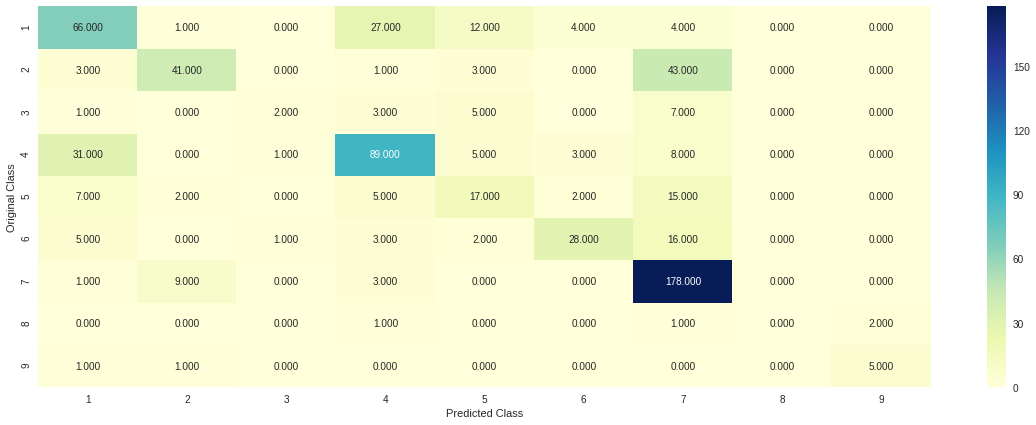

-------------------Precision Heatmap--------------------


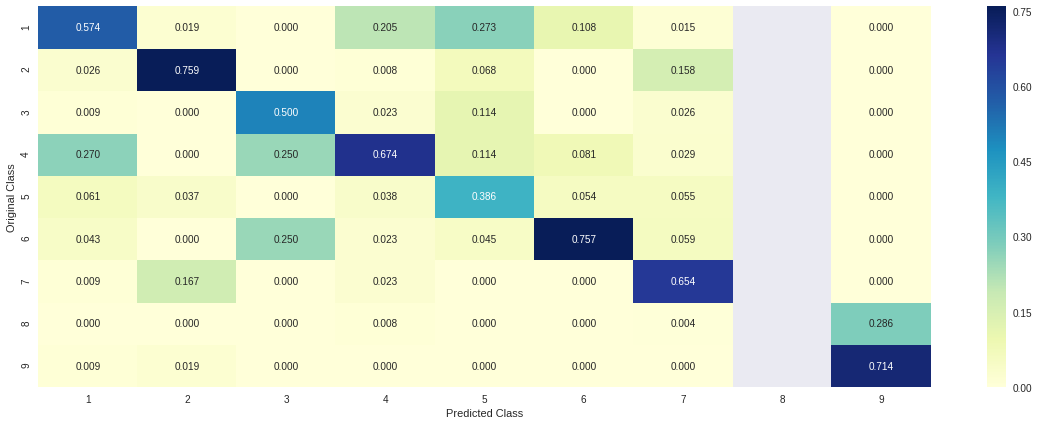

--------------------------Recall Heatmap--------------------------


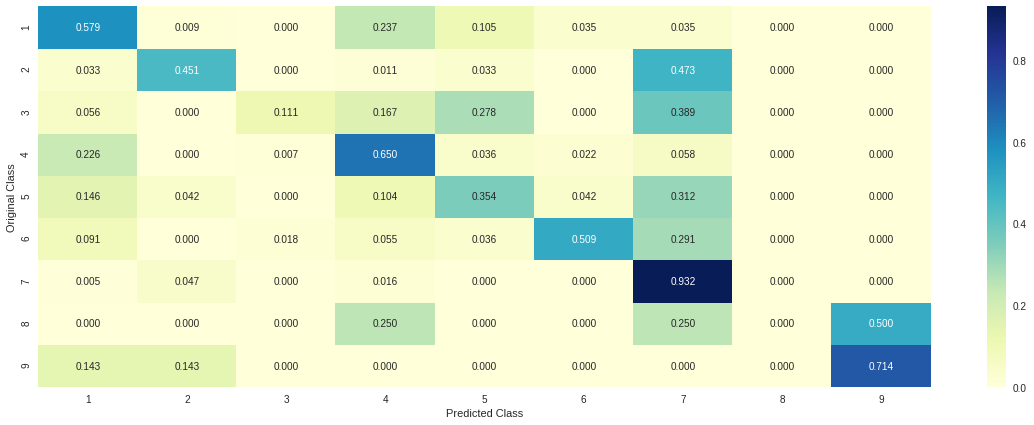

Misclassification Rate:  35.93984962406015 %


In [36]:
#-------------------------Modelling with SVM---------------------------

alpha_range = [0.00001,0.0001,0.001,0.01, 0.1,1,10,100,1000]
logloss = []
for alpha in alpha_range:
  SVM = SGDClassifier(alpha = alpha, penalty = "l2", loss = "hinge", random_state = 42)
  SVM.fit(X_tr,y_tr)
  sig_clf = CalibratedClassifierCV(SVM, method="sigmoid")
  sig_clf.fit(X_tr, y_tr)
  prediction = sig_clf.predict_proba(X_cv)
  loss = log_loss(y_true = y_cv, y_pred = prediction)
  logloss.append(loss)
  print("Logloss for alpha:",alpha, " is: ",loss)
  
  
best_alpha = alpha_range[np.argmin(logloss)]

SVM = SGDClassifier(alpha = best_alpha, penalty = "l2", loss = "hinge", random_state = 42)
SVM.fit(X_tr, y_tr)
sig_clf = CalibratedClassifierCV(SVM, method = "sigmoid")
sig_clf.fit(X_tr, y_tr)
#prediction = sig_clf.predict_proba(df_cv)
#loss = log_loss(y_true = y_cv, y_pred = prediction)

print(" ")
prediction_tr = sig_clf.predict_proba(X_tr)
print("Log loss for alpha :",best_alpha ," and Training set is:", log_loss(y_true = y_tr, y_pred = prediction_tr))

prediction_cv = sig_clf.predict_proba(X_cv)
print("Log loss for alpha :",best_alpha ," and Cross Validation set is:", log_loss(y_true = y_cv, y_pred = prediction_cv))

prediction_test = sig_clf.predict_proba(X_test)
print("Log loss for alpha :",best_alpha ," and Testing set is:", log_loss(y_true = y_test, y_pred = prediction_test))

predict = sig_clf.predict(X_test)
plot_confusion_matrix(y_test, predict)

##5.10) Modelling: Random Forest

Logloss for alpha: 100 and depth: 5  is:  1.1058791301285757
Logloss for alpha: 100 and depth: 10  is:  1.1251003336240393
Logloss for alpha: 200 and depth: 5  is:  1.0929380691189239
Logloss for alpha: 200 and depth: 10  is:  1.12222759947912
Logloss for alpha: 500 and depth: 5  is:  1.0779503750581754
Logloss for alpha: 500 and depth: 10  is:  1.117590281696541
Logloss for alpha: 1000 and depth: 5  is:  1.0766559625398557
Logloss for alpha: 1000 and depth: 10  is:  1.1138410316697491
Logloss for alpha: 2000 and depth: 5  is:  1.0727377193459027
Logloss for alpha: 2000 and depth: 10  is:  1.1151967537719638
 
Log loss for alpha : 2000 and max depth of: 5  for Training set is: 0.7158346620501634
Log loss for alpha : 2000 and max depth of: 5  for Cross Validation set is: 1.0727377193459027
Log loss for alpha : 2000 and max depth of: 5  for Testing set is: 1.1869269529948485
--------------------Confusion Matrix------------------


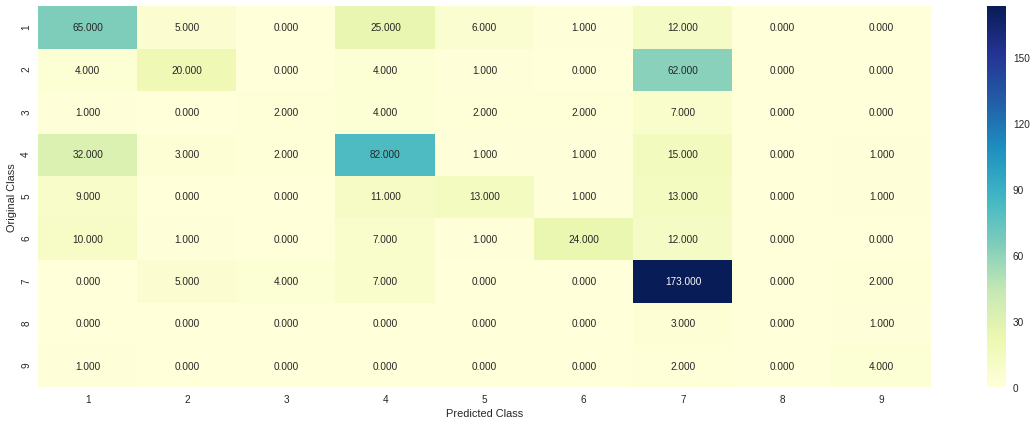

-------------------Precision Heatmap--------------------


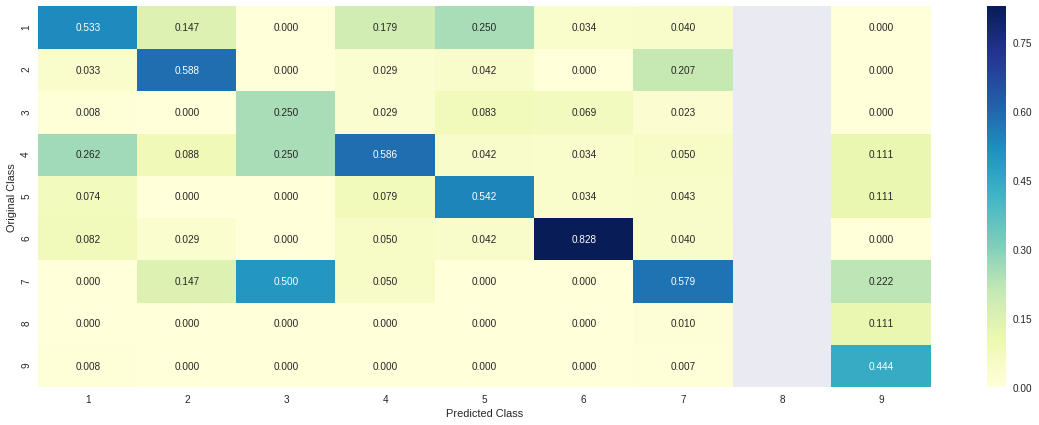

--------------------------Recall Heatmap--------------------------


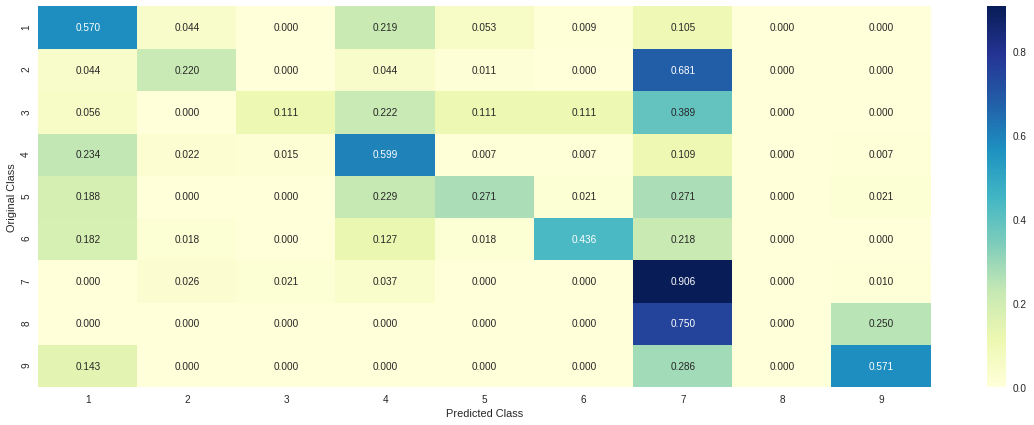

Misclassification Rate:  42.40601503759399 %


In [37]:
#-------------------------Modelling with Random Forest---------------------------

alpha_range = [100,200,500,1000,2000]
max_depth = [5,10]
logloss = []
for alpha in alpha_range:
  for depth in max_depth:
    RF = RandomForestClassifier(n_estimators = alpha, criterion = "gini", max_depth = depth, n_jobs = -1, random_state = 42)
    RF.fit(X_tr,y_tr)
    sig_clf = CalibratedClassifierCV(RF, method="sigmoid")
    sig_clf.fit(X_tr, y_tr)
    prediction = sig_clf.predict_proba(X_cv)
    loss = log_loss(y_true = y_cv, y_pred = prediction)
    logloss.append(loss)
    print("Logloss for alpha:",alpha,"and depth:",depth, " is: ",loss)
  
  
best_alpha = np.argmin(logloss)

RF = RandomForestClassifier(n_estimators = alpha_range[int(best_alpha/2)], criterion = "gini", max_depth =max_depth[(best_alpha % 2)] , n_jobs = -1, random_state = 42)
RF.fit(X_tr, y_tr)
sig_clf = CalibratedClassifierCV(RF, method = "sigmoid")
sig_clf.fit(X_tr, y_tr)
#prediction = sig_clf.predict_proba(df_cv)
#loss = log_loss(y_true = y_cv, y_pred = prediction)

print(" ")
prediction_tr = sig_clf.predict_proba(X_tr)
print("Log loss for alpha :",alpha_range[int(best_alpha/2)] ,"and max depth of:",max_depth[(best_alpha % 2)]," for Training set is:", log_loss(y_true = y_tr, y_pred = prediction_tr))

prediction_cv = sig_clf.predict_proba(X_cv)
print("Log loss for alpha :",alpha_range[int(best_alpha/2)] ,"and max depth of:",max_depth[(best_alpha % 2)]," for Cross Validation set is:", log_loss(y_true = y_cv, y_pred = prediction_cv))

prediction_test = sig_clf.predict_proba(X_test)
print("Log loss for alpha :",alpha_range[int(best_alpha/2)] ,"and max depth of:",max_depth[(best_alpha % 2)]," for Testing set is:", log_loss(y_true = y_test, y_pred = prediction_test))

predict = sig_clf.predict(X_test)
plot_confusion_matrix(y_test, predict)

##5.11) Modelling: Stacking Classifier

Stacking Classifier: Log Loss for alpha: 1e-05  is: 2.1959735499433335
Stacking Classifier: Log Loss for alpha: 0.0001  is: 2.184913628000634
Stacking Classifier: Log Loss for alpha: 0.001  is: 2.0909927636904078
Stacking Classifier: Log Loss for alpha: 0.01  is: 1.609275572586561
Stacking Classifier: Log Loss for alpha: 0.1  is: 1.0559053480465816
Stacking Classifier: Log Loss for alpha: 1  is: 1.1030993440599572
Stacking Classifier: Log Loss for alpha: 10  is: 1.5178722676447756
Stacking Classifier: Log Loss for alpha: 100  is: 2.1578559139782953
Log loss for Training set: 0.4280260224555615
Log loss for CV set: 1.0559053480465816
Log loss for Test set: 1.1640645843252921
--------------------Confusion Matrix------------------


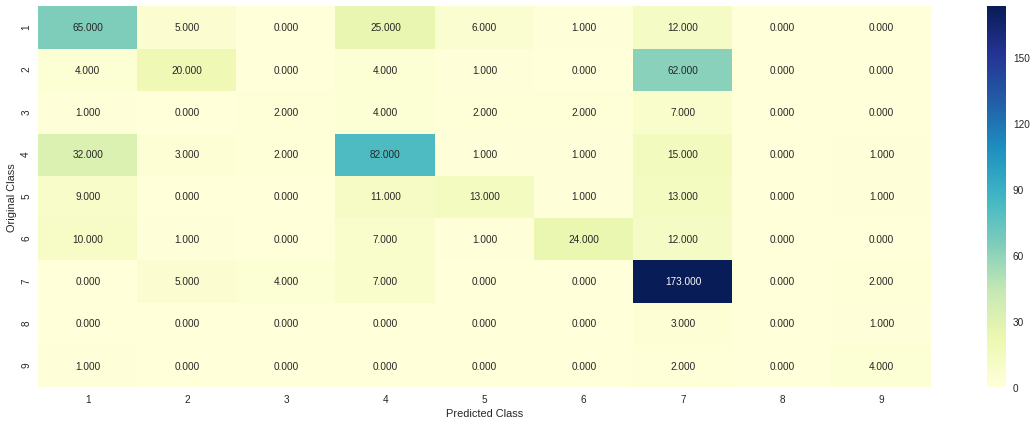

-------------------Precision Heatmap--------------------


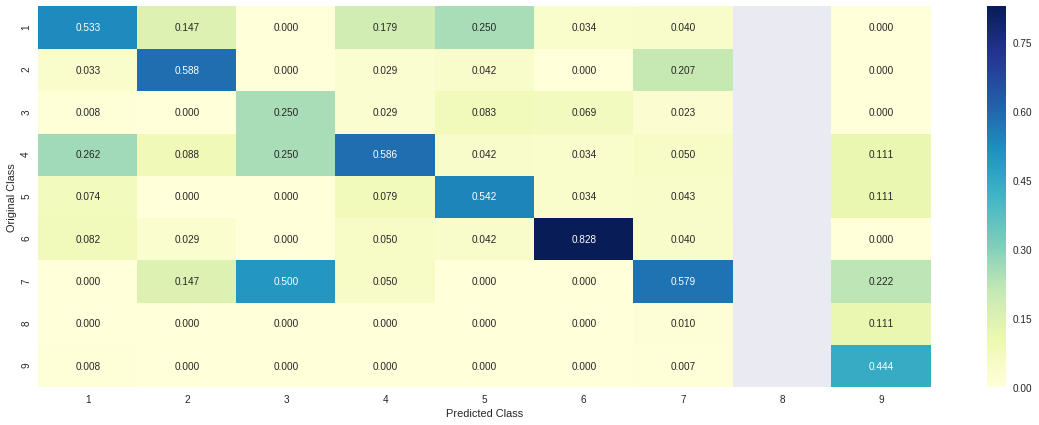

--------------------------Recall Heatmap--------------------------


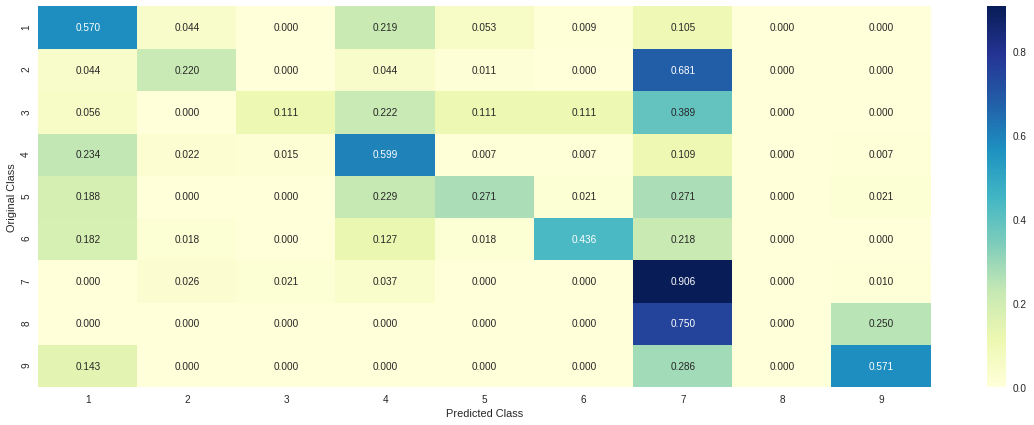

Misclassification Rate:  42.40601503759399 %


In [38]:
#-------------------------Modelling with Stacking Classifier---------------------------
'''
#Multinomial Naive Bayes
NB = MultinomialNB(alpha = 0.001)
NB.fit(df_tr, y_tr)
sig_clf1 = CalibratedClassifierCV(NB, method = "sigmoid")
'''
#Logistic Regression
LR = LogisticRegression(C = 10, penalty = "l2", class_weight = "balanced")
LR.fit(X_tr, y_tr)
sig_clf2 = CalibratedClassifierCV(LR, method = "sigmoid")

#Linear Support Vector Machines
SVM = SGDClassifier(alpha =0.0001 , penalty = "l2", loss = "hinge", random_state = 42)
SVM.fit(X_tr, y_tr)
sig_clf3 = CalibratedClassifierCV(SVM, method = "sigmoid")

#sig_clf1.fit(df_tr, y_tr)
sig_clf2.fit(X_tr, y_tr)
sig_clf3.fit(X_tr, y_tr)

alpha_range = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
logloss = []
for alpha in alpha_range:
  lr = LogisticRegression(C = alpha, penalty = "l2", class_weight = "balanced")
  stack = StackingClassifier(classifiers = [sig_clf2, sig_clf3], use_probas = True, meta_classifier = lr)
  stack.fit(X_tr, y_tr)
  prediction = stack.predict_proba(X_cv)
  loss = log_loss(y_true = y_cv, y_pred = prediction)
  print("Stacking Classifier: Log Loss for alpha:", alpha," is:", loss)
  logloss.append(loss)
  
  
best_alpha = alpha_range[np.argmin(logloss)]


lr = LogisticRegression(C = best_alpha, penalty = "l2", class_weight = "balanced")
stack = StackingClassifier(classifiers=[sig_clf2, sig_clf3], use_probas = True, meta_classifier = lr)
stack.fit(X_tr, y_tr)

prediction_tr = stack.predict_proba(X_tr)
loss_tr = log_loss(y_true = y_tr, y_pred =prediction_tr )
print("Log loss for Training set:", loss_tr)

prediction_cv = stack.predict_proba(X_cv)
loss_cv = log_loss(y_true = y_cv, y_pred =prediction_cv )
print("Log loss for CV set:", loss_cv)

prediction_test = stack.predict_proba(X_test)
loss_test = log_loss(y_true = y_test, y_pred =prediction_test )
print("Log loss for Test set:", loss_test)

predict = sig_clf.predict(X_test)
plot_confusion_matrix(y_test, predict)

#6) Conclusion

In [0]:
#Putting all the logloss values for all the models in the table to summarize the results.

table = [["Naive Bayes",0.60434,1.14260,1.26447, "41.954%"],["Logistic Regression with class balancing",0.41197,0.93845,1.06064,"36.691%"],["SVM",0.45602,0.97895,1.10711,"35.939%"],["Random Forest",0.71583,1.07273,1.18692,"42.406%"],["Stacking Classifier",0.42802,1.05590,1.16406,"42.406%"]]
table_df = pd.DataFrame(data = table, columns = ["Model","Logloss_Training","Logloss_CV","Logloss_Test","Misclassification rate"])


In [47]:
table_df

,Model,Logloss_Training,Logloss_CV,Logloss_Test,Misclassification rate
0,Naive Bayes,0.60434,1.14260,1.26447,41.954%
1,Logistic Regression with class balancing,0.41197,0.93845,1.06064,36.691%
2,SVM,0.45602,0.97895,1.10711,35.939%
3,Random Forest,0.71583,1.07273,1.18692,42.406%
4,Stacking Classifier,0.42802,1.05590,1.16406,42.406%


##Observation:

1) Looking at the above table, we can see that Logistic Regression with class balancing is the best available model with Log loss for Test set as 1.06064

